# Study of the Competencies of primary schools in Catalonia focusing on the nature of the centre

The aim of this section of the project is to analyze what roles public and private schools play at Catalonia.
In order to do so, I will
1. Understand how schools are distributed in Catalonia, depending on the nature of the centre,
2. Compare private and public schools in educational achivement, preferably differentiating between subjects
3. Correlate the school achievement in private schools with the expenditure in them, both in time, and spatially.

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
import seaborn as sns
import pprint
from sodapy import Socrata
import os

## Database- 6e de primaria

In [4]:
# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000)

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

# Modify what it is wrong in the dataframe:
comp['genere'] = comp['genere'].replace({'Home': 'H', 'Dona': 'D'})

## Database expenditure on private schools

In [5]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("8spq-9nx7",limit=10000)

# Convert to pandas DataFrame
gastos = pd.DataFrame.from_records(results)

# We only want to analyze Primary Schools
gprim= gastos.dropna(subset=['unitats_concertades_pri'])

## 1. Distribution of private and public schools in Catalonia
### Gender

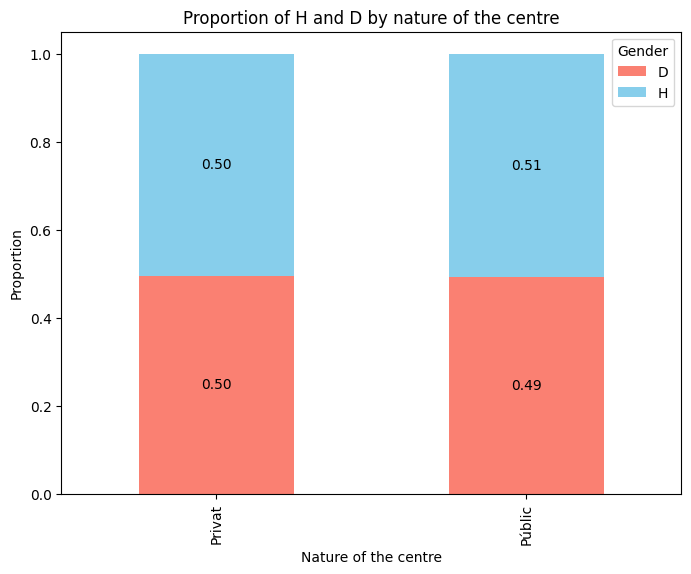

In [6]:
# Comparison of gender

import matplotlib.pyplot as plt

# Step 1: Calculate the counts of "H" and "D" for each category
counts = comp.groupby(['naturalesa', 'genere']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Customize the plot
plt.title('Proportion of H and D by nature of the centre')
plt.xlabel('Nature of the centre')
plt.ylabel('Proportion')
plt.legend(title='Gender')

# Adding proportion labels on each bar
for i, (index, row) in enumerate(proportions.iterrows()):
    cumulative_height = 0  # Keeps track of where to place each label
    for j, proportion in enumerate(row):
        cumulative_height += proportion
        ax.text(i, cumulative_height - proportion / 2, f"{proportion:.2f}", ha='center', va='center', color='black')

plt.show()


### Spatial distribution

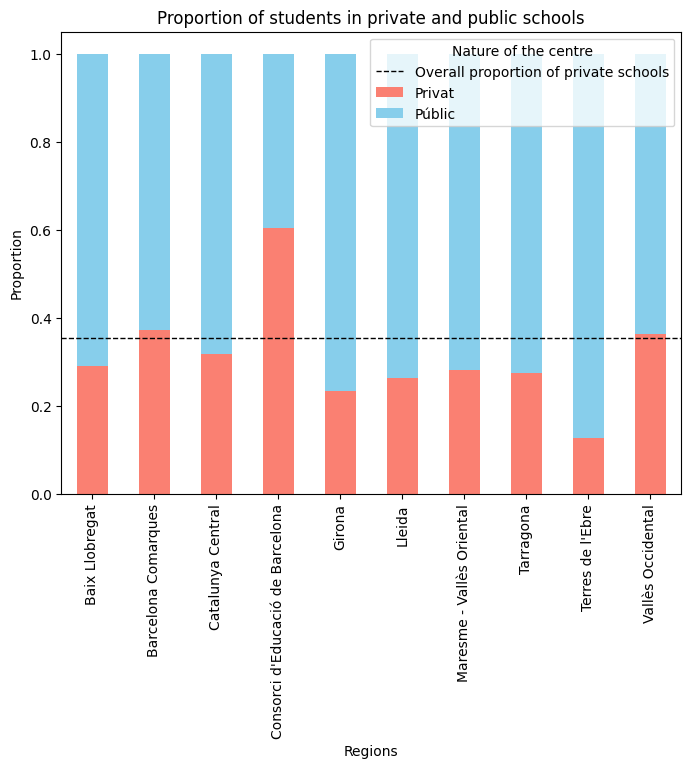

In [7]:
# Step 1: Calculate the counts of "Privat" and "Públic" for each category
counts = comp.groupby(['area_territorial', 'naturalesa']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Calculate the overall counts of each 'naturalesa' category (e.g., private and public) across all areas
ccounts = comp['naturalesa'].value_counts()

# Calculate the overall proportion for "Privat" as a single value
hvalue = ccounts['Privat'] / (ccounts['Privat'] + ccounts['Públic'])

# Draw a single horizontal line for the overall "Privat" proportion
ax.axhline(y=hvalue, color='black', linestyle='--', linewidth=1, label='Overall proportion of private schools')

# Customize the plot
plt.title('Proportion of students in private and public schools')
plt.xlabel('Regions')
plt.ylabel('Proportion')
plt.legend(title='Nature of the centre')
plt.show()


#### Let's try with maps

In [8]:
mncps = gpd.read_file("../data/Municipis/mncps.shp")
mncps.rename(columns={'NOMREGIO': 'area_territorial', 'NOMMUNI': 'municipi'}, inplace=True)

regions = gpd.read_file("../data/Municipis/regions.shp")
regions.rename(columns={'NOMREGIO': 'area_territorial'}, inplace=True)

# Add region code
regions['code'] = range(len(regions))

# Add the coordinates to the dataframe
comp2 = comp.merge(regions, on='area_territorial')

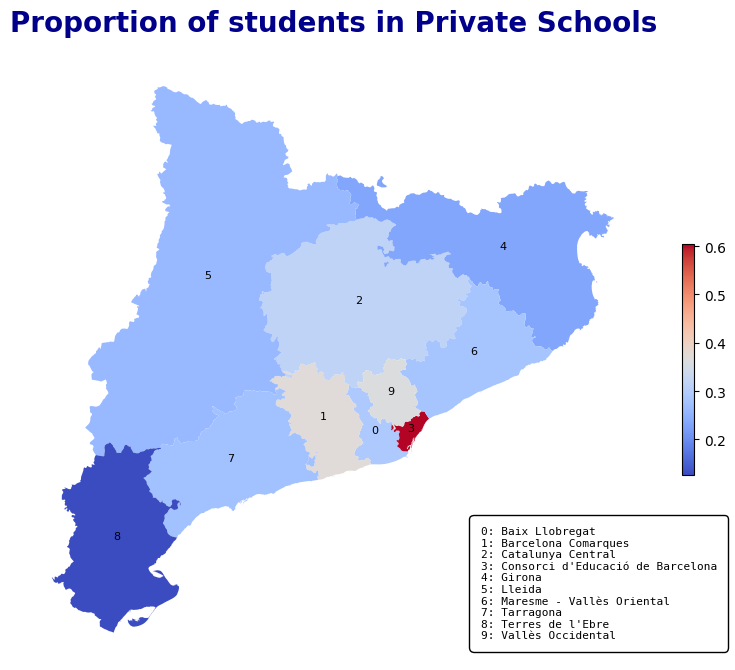

In [38]:
# Merge proportions and regions to form proportions_gdf
proportions2 = proportions.merge(regions, on='area_territorial')
proportions_gdf = gpd.GeoDataFrame(proportions2, geometry='geometry')

# Plot the map with regions colored by 'Privat'
fig, ax = plt.subplots(figsize=(10, 10))
proportions_gdf.plot(column='Privat', 
                     ax=ax, 
                     legend=True, 
                     cmap='coolwarm',  
                     missing_kwds={"color": "lightgrey", "label": "No data"},
                     legend_kwds={'shrink': 0.3})  

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            row['code'], fontsize=8, ha='center', color='black')

# Create a string for the mapping of codes to region names
legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

# Create a box for the legend
legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                 child=legend_box,
                                 pad=0.5,
                                 frameon=True,  # Enable the box frame
                                 bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                 bbox_transform=fig.transFigure,  # Use figure coordinates
                                 borderpad=0.5)
anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
ax.add_artist(anchored_box)

# Customize the title
plt.title('Proportion of students in Private Schools', 
          fontsize=20,         
          fontweight='bold',   
          color='darkblue',    
          loc='center',        
          pad=20)              

plt.axis('off')  # Hide axes
plt.show()



In [10]:
proportions_gdf

,area_territorial,Privat,Públic,geometry,code
0,Baix Llobregat,0.290053,0.709947,"POLYGON ((416496.693 4568594.713, 416494.027 4...",0
1,Barcelona Comarques,0.372619,0.627381,"MULTIPOLYGON (((395328.020 4563737.970, 395280...",1
2,Catalunya Central,0.316417,0.683583,"MULTIPOLYGON (((374079.248 4610945.985, 374076...",2
3,Consorci d'Educació de Barcelona,0.604634,0.395366,"MULTIPOLYGON (((430672.760 4576094.500, 430638...",3
4,Girona,0.232353,0.767647,"MULTIPOLYGON (((471904.065 4651635.777, 471575...",4
5,Lleida,0.261943,0.738057,"MULTIPOLYGON (((304547.841 4575431.598, 304265...",5
6,Maresme - Vallès Oriental,0.281438,0.718562,"MULTIPOLYGON (((440741.854 4591175.189, 440657...",6
7,Tarragona,0.274780,0.725220,"MULTIPOLYGON (((319540.469 4547243.953, 319962...",7
8,Terres de l'Ebre,0.126486,0.873514,"MULTIPOLYGON (((295273.291 4497586.320, 295229...",8
9,Vallès Occidental,0.363518,0.636482,"MULTIPOLYGON (((427306.316 4588229.172, 427266...",9


## 2. Educational achievement

In [11]:
# Calculate mean grades, not french
comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].apply(pd.to_numeric, errors='coerce')
comp2['mean_grade'] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].mean(axis=1)


Comparison of grades over regions

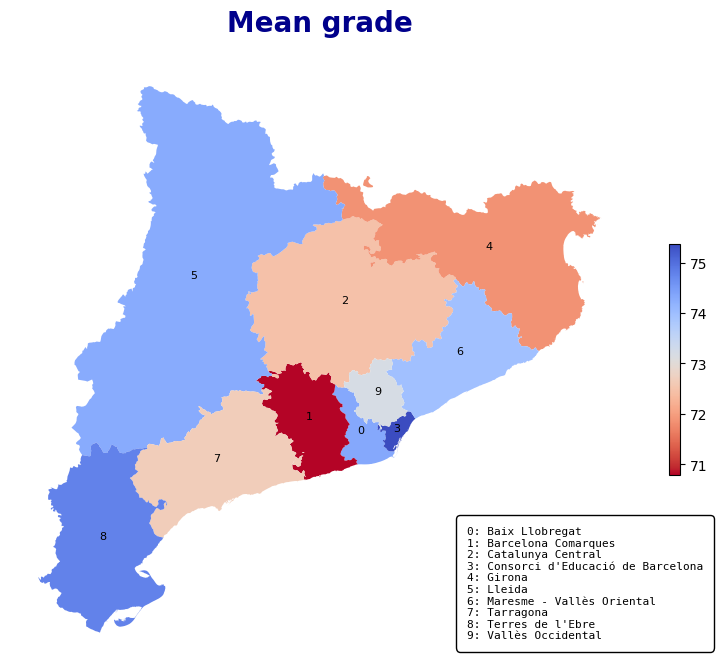

In [44]:
means_by_area = comp2[comp2['any'] == '2023'].groupby('area_territorial', as_index=False)['mean_grade'].mean()
means_by_area = means_by_area.merge(regions, on='area_territorial')
means_by_area = gpd.GeoDataFrame(means_by_area, geometry='geometry')

# Plot the map with regions colored by 'mean_grade'
fig, ax = plt.subplots(figsize=(10, 10))
means_by_area.plot(column='mean_grade', 
                     ax=ax, 
                     legend=True, 
                     cmap='coolwarm_r',  
                     missing_kwds={"color": "lightgrey", "label": "No data"},
                     legend_kwds={'shrink': 0.3})  

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            row['code'], fontsize=8, ha='center', color='black')

# Create a string for the mapping of codes to region names
legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

# Create a box for the legend
legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                 child=legend_box,
                                 pad=0.5,
                                 frameon=True,  # Enable the box frame
                                 bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                 bbox_transform=fig.transFigure,  # Use figure coordinates
                                 borderpad=0.5)
anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
ax.add_artist(anchored_box)

# Customize the title
plt.title('Mean grade', 
          fontsize=20,         
          fontweight='bold',   
          color='darkblue',    
          loc='center',        
          pad=20)              

plt.axis('off')  # Hide axes
plt.show()



In [45]:
c_priv = comp2[comp2["naturalesa"] == "Privat"].copy()
c_priv.rename(columns={'any': 'curs_escolar'}, inplace=True)

c_pub = comp2[comp2["naturalesa"] == "Públic"].copy()
c_pub.rename(columns={'any': 'curs_escolar'}, inplace=True)

### Comparison Public-Private in 2023

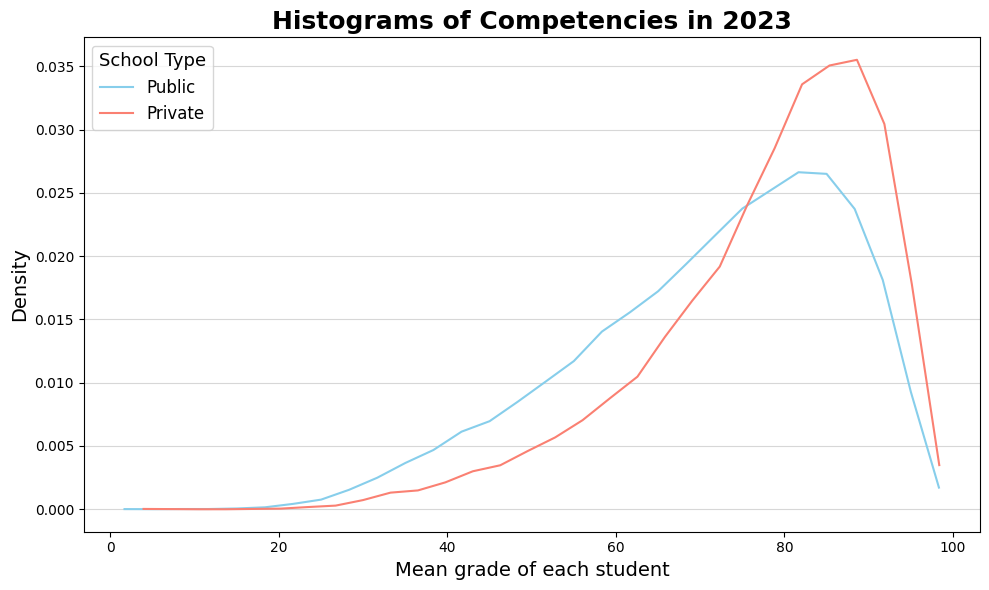

In [46]:
year = '2023'
pub23 = c_pub[c_pub['curs_escolar'] == year].copy()
priv23 = c_priv[c_priv['curs_escolar'] == year].copy()
# Clean the data
pub23_clean = pd.to_numeric(pub23.mean_grade, errors='coerce').dropna()
priv23_clean = pd.to_numeric(priv23.mean_grade, errors='coerce').dropna()

# Plot the histograms using plt.hist()
plt.figure(figsize=(10, 6))
hist1, bin_edges1 = np.histogram(pub23_clean, bins = 30, density = True)
bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1]) / 2
hist2, bin_edges2 = np.histogram(priv23_clean, bins = 30, density = True)
bin_centers2 = (bin_edges2[1:] + bin_edges2[:-1]) / 2


# Customize the plot
plt.plot(bin_centers1, hist1,  label = 'Public', color = 'skyblue')
plt.plot(bin_centers2, hist2,label = 'Private', color = 'salmon')
plt.title("Histograms of Competencies in 2023", fontsize=18, fontweight='bold')
plt.xlabel("Mean grade of each student", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(title="School Type", fontsize=12, title_fontsize=13)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


Next steps:
* A map showing the expenditure per private school (?)
* A time evolution graph showing the average grades of private shcools and the expenditure
* **A scatter plot showing the correlation between expenditure and grades, with its error bar...**

### Achievement-expenditure correlation

In [ ]:
display(pub23.pmed.head())


25    91.67
52    42.36
72    75.28
89    70.83
96    55.83
Name: pmed, dtype: object

In [ ]:
pub23.columns

Index(['curs_escolar', 'codi_alumne', 'pcat', 'pcat_cl', 'pcat_ee', 'pcast',
       'pcast_cl', 'pcast_ee', 'pmat', 'pmat_nc', 'pmat_efm', 'pmat_cr',
       'pang', 'pang_co', 'pang_ce', 'pang_ee', 'pcat_co', 'pcast_co', 'pmed',
       'pmed_comp1', 'pmed_comp2', 'pmed_comp3', 'genere', 'mes_naixement',
       'any_naixement', 'area_territorial', 'naturalesa', 'h_bitat', 'pfran',
       'pfran_co', 'pfran_ce', 'pfran_ee', 'geometry', 'code'],
      dtype='object')

In [50]:
gprim.columns

Index(['curs_escolar', 'codi_centre', 'nom_centre', 'municipi', 'titularitat',
       'unitats_concertades_ede', 'alumnes_ede', 'dotaci_plantilla', 'brut',
       'seg_social', 'despeses_de_funcionament', 'unitats_concertades_einf',
       'unitats_concertades_pri', 'unitats_concertades_eso', 'alumnes_einf',
       'alumnes_pri', 'alumnes_eso', 'unitats_concertades_cfpm',
       'alumnes_batx', 'alumnes_cfpm', 'alumnes_cfps',
       'unitats_concertades_batx', 'unitats_concertades_cfps'],
      dtype='object')

In [ ]:
# Important
gprim2 = gprim.copy()
gprim2['curs_escolar'] = gprim['curs_escolar'].str.split('-').str[1]


1    2023
2    2023
3    2023
4    2023
5    2023
Name: curs_escolar, dtype: object

In [ ]:
gprim.municipi
mncps.NOMMUNI

0      Abella de la Conca
1                  Abrera
2                    Àger
3                Agramunt
4      Aguilar de Segarra
              ...        
942               Vinaixa
943               Vinebre
944    Vinyols i els Arcs
945     Viver i Serrateix
946                 Xerta
Name: NOMMUNI, Length: 947, dtype: object

In [ ]:
c_priv.rename(columns = {'any': 'curs_escolar'}, inplace= True)

In [ ]:
print("Media Mat Global. Privado:", pd.to_numeric(c_priv.pmat, errors = "coerce").mean())

Media Mat Global. Privado: 80.1785513028783


### Database- expenditure

In [ ]:
gprim[gprim["curs_escolar"] == "2022-2023"]

,curs_escolar,codi_centre,nom_centre,municipi,titularitat,unitats_concertades_ede,alumnes_ede,dotaci_plantilla,brut,seg_social,...,unitats_concertades_eso,alumnes_einf,alumnes_pri,alumnes_eso,unitats_concertades_cfpm,alumnes_batx,alumnes_cfpm,alumnes_cfps,unitats_concertades_batx,unitats_concertades_cfps
1,2022-2023,08031356,Montagut,Vilafranca del Penedès,Fundació Escola Montagut,NaN,NaN,3968,1582731.95,504891.4921,...,8,148,316,243,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-2023,08031371,Sant Josep,Vilafranca del Penedès,Fundació Esc. Sant Josep de Vilafranca,NaN,NaN,1972,859613.94,274216.8469,...,4,70,159,117,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-2023,08031401,Sant Ramon de Penyafort,Vilafranca del Penedès,"Sagrada Família, Fills de la",NaN,NaN,3768,1600690.83,510620.3748,...,8,124,306,229,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-2023,08031381,Vedruna Vilafranca del Penedès,Vilafranca del Penedès,Fundació Vedruna Catalunya Educació,NaN,NaN,3768,1539828.94,491205.4319,...,8,126,301,239,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-2023,08031599,Divina Providència,Vilanova i la Geltrú,FUnd.Clarisses Div.Prov.Vilanova Geltrú,NaN,NaN,1972,800229.64,255273.2552,...,4,58,145,111,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,2022-2023,08032555,Goar,Viladecans,"Escola Goar, SL",NaN,NaN,4508,1846245.99,588952.4708,...,8,115,284,240,NaN,128,0,0,4,NaN
677,2022-2023,08031150,Sagrada Família,Viladecans,Inst.Hnas. Sagrada Familia de Urgell,NaN,NaN,3902,1702450.63,543081.751,...,8,90,284,242,NaN,NaN,NaN,NaN,NaN,NaN
678,2022-2023,08031231,Sant Gabriel,Viladecans,"St. Gabriel, Germans de",NaN,NaN,5104,2242671.49,715412.2053,...,8,137,295,240,4,0,118,91,NaN,4
679,2022-2023,08031125,Santo Tomás,Viladecans,"Cultursport, SL",NaN,NaN,13,522322.27,166620.8041,...,NaN,52,126,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Step 1: Calculate the counts of "H" and "D" for each category
counts = gastos.groupby(['municipi', 'naturalesa']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Calculate the overall counts of each 'naturalesa' category (e.g., private and public) across all areas
ccounts = comp['naturalesa'].value_counts()

# Calculate the overall proportion for "Privat" as a single value
hvalue = ccounts['Privat'] / (ccounts['Privat'] + ccounts['Públic'])

# Draw a single horizontal line for the overall "Privat" proportion
ax.axhline(y=hvalue, color='black', linestyle='--', linewidth=1, label='Overall proportion')

# Customize the plot
plt.title('Proportion of private and public schools')
plt.xlabel('Regions')
plt.ylabel('Proportion')
plt.legend(title='Nature of the centre')
plt.show()



KeyError: 'naturalesa'

In [ ]:
gastos.columns
gastos.index

RangeIndex(start=0, stop=4160, step=1)